### Effect of the smoothing kernel used for the wavelet coherence

In this notebook we use the autoregressive example model from [Dhamala et. al.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.100.018701). The model consists of two coupled random variables ($2\rightarrow 1$), the coupling is time-varying therefore the coherence should detect the coupling dynamics. The model is given by the equations bellow:

$X_{1}(t) = 0.55X_{1}(t-1)-0.8X_{1}(t-2)+C(t)X_{2}(t-1)+\epsilon (t)$

$X_{2}(t) = 0.55X_{2}(t-1)-0.8X_{2}(t-2)+\xi (t)$

Here, $X_1(t)$ and $X_2(t)$ are $AR(2)$. The variable $t$ is the time step index,
such that the actual time is $t'=t\,\Delta t=t/f_{\rm s}$. Besides, we know by construction that
$X_2(t)$ influences $X_1(t)$ through the coupling constant $C$
(although the opposite does not happen). In the simulation $C(t)=0.25$ for $t<15$ s, and zero otherwise. 

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

import os
import time

import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import xarray as xr
from mne.time_frequency.tfr import morlet
from scipy.signal import fftconvolve
from tqdm import tqdm
from xfrites.conn.conn_coh import _tf_decomp, conn_coherence_wav

import GDa.graphics.plot as plot

In [2]:
# Create directory to save figures
if not os.path.exists("img/n3.0.6"):
    os.makedirs("img/n3.0.6")

In [3]:
def gaussenvmorlet(sfreq, freqs, n_cycles=7.0, sigma=None, zero_mean=False):
    Ws = list()
    n_cycles = np.atleast_1d(n_cycles)

    freqs = np.array(freqs)
    if np.any(freqs <= 0):
        raise ValueError("all frequencies in 'freqs' must be " "greater than 0.")

    if (n_cycles.size != 1) and (n_cycles.size != len(freqs)):
        raise ValueError("n_cycles should be fixed or defined for " "each frequency.")
    for k, f in enumerate(freqs):
        if len(n_cycles) != 1:
            this_n_cycles = n_cycles[k]
        else:
            this_n_cycles = n_cycles[0]
        # fixed or scale-dependent window
        if sigma is None:
            sigma_t = this_n_cycles / (2.0 * np.pi * f)
        else:
            sigma_t = this_n_cycles / (2.0 * np.pi * sigma)
        t = np.arange(0.0, 5.0 * sigma_t, 1.0 / sfreq)
        t = np.r_[-t[::-1], t[1:]]
        #  oscillation = np.exp(2.0 * 1j * np.pi * f * t)
        gaussian_enveloppe = np.exp(-(t ** 2) / (2.0 * sigma_t ** 2))
        W = gaussian_enveloppe / np.sum(gaussian_enveloppe)
        Ws.append(W)
    # Pad with zeros to convert to numpy array
    max_length = max(len(row) for row in Ws)
    for i in range(len(Ws)):
        Ws[i] = np.pad(
            Ws[i], ((max_length - len(Ws[i])) // 2, (max_length - len(Ws[i])) // 2)
        )
    return np.array(Ws)

#### Defining function to simulate de model

In [4]:
def ar_model_dhamala(
    N=5000, Trials=10, Fs=200, C=0.2, t_start=0, t_stop=None, cov=None
):
    """
    AR model from Dhamala et. al.
    """

    T = N / Fs

    time = np.linspace(0, T, N)

    X = np.random.random([Trials, N])
    Y = np.random.random([Trials, N])

    def interval(t, t_start, t_stop):
        if t_stop == None:
            return t >= t_start
        else:
            return (t >= t_start) * (t <= t_stop)

    for i in tqdm(range(Trials)):
        E = np.random.multivariate_normal(np.zeros(cov.shape[0]), cov, size=(N,))
        for t in range(2, N):
            X[i, t] = (
                0.55 * X[i, t - 1]
                - 0.8 * X[i, t - 2]
                + interval(time[t], t_start, t_stop) * C * Y[i, t - 1]
                + E[t, 0]
            )
            Y[i, t] = 0.55 * Y[i, t - 1] - 0.8 * Y[i, t - 2] + E[t, 1]

    Z = np.zeros([Trials, 2, N])

    Z[:, 0, :] = X
    Z[:, 1, :] = Y

    return Z

Model parameters

In [5]:
N = 5000  # Number of observations
Fs = 200  # Sampling frequency
dt = 1.0 / Fs  # Time resolution
C = 0.25  # Coupling parameter
Trials = 1  # Number of trials
freqs = np.arange(1, 100, 1)  # Frequency axis
# Covariance matrix
cov = np.array([[1.00, 0.00], [0.00, 1.00]])

Generating data

In [6]:
# Generating data
X = ar_model_dhamala(N=N, Trials=Trials, C=C, Fs=Fs, t_start=0, t_stop=15, cov=cov)

100%|██████████████████████████████| 1/1 [00:00<00:00, 26.11it/s]


In [7]:
X = xr.DataArray(
    X,
    dims=("trials", "roi", "times"),
    coords=(np.arange(Trials), ["r0", "r1"], np.arange(N) / Fs),
)

### TF analysis

In [8]:
def compute_coherence(freqs, n_cycles):
    # Get the Gaussian component of the wavelets
    wavelets = gaussenvmorlet(Fs, freqs, n_cycles=n_cycles, sigma=None, zero_mean=False)
    # Wavelet coefficients
    W = _tf_decomp(
        X,
        Fs,
        freqs,
        mode="morlet",
        n_cycles=n_cycles,
        mt_bandwidth=None,
        decim=1,
        kw_cwt={},
        kw_mt={},
        n_jobs=-1,
    ).squeeze()
    # Auto-spectra
    Sxx = (W * np.conj(W)).real
    # Smoothed auto-spectra
    sSxx = np.zeros_like(Sxx)
    # for i,w in enumerate(wavelets):
    #    sSxx[0,i] = fftconvolve(Sxx[0,i], w, mode="same", axes=-1)
    #    sSxx[1,i] = fftconvolve(Sxx[1,i], w, mode="same", axes=-1)
    sSxx[0] = fftconvolve(Sxx[0], wavelets, mode="same", axes=-1)
    sSxx[1] = fftconvolve(Sxx[1], wavelets, mode="same", axes=-1)
    # Cross-spectra
    Sxy = W[0] * np.conj(W[1])
    # Smoothed cross-spectra
    sSxy = np.zeros_like(Sxy)
    # for i,w in enumerate(wavelets):
    #    sSxy[i] = fftconvolve(Sxy[i], w, mode="same", axes=-1)
    sSxy = fftconvolve(Sxy, wavelets, mode="same", axes=-1)
    # Coherene with Gaussian kernel
    # C  = np.abs(Sxy)**2/(Sxx[0]*Sxx[1])
    sC = np.abs(sSxy) ** 2 / (sSxx[0] * sSxx[1])

    # Coherence with square and hanning kernel
    c_square = conn_coherence_wav(
        X,
        freqs,
        sfreq=Fs,
        sm_kernel="square",
        sm_times=1.5,
        n_cycles=n_cycles,
        n_jobs=-1,
    ).squeeze()
    c_hanning = conn_coherence_wav(
        X,
        freqs,
        sfreq=Fs,
        sm_kernel="hanning",
        sm_times=1.5,
        n_cycles=n_cycles,
        n_jobs=-1,
    ).squeeze()
    return sC, c_square, c_hanning

In [9]:
sC1, c_square1, c_hanning1 = compute_coherence(freqs, 6)
sC2, c_square2, c_hanning2 = compute_coherence(freqs, freqs / 2)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.0s finished
WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=99, decim=1, sm_times=300, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    0.6s finished


  0%|          | Estimating pairwise coherence : 0/1 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=99, decim=1, sm_times=300, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.0s finished


  0%|          | Estimating pairwise coherence : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.0s finished
WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=99, decim=1, sm_times=300, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    0.6s finished


  0%|          | Estimating pairwise coherence : 0/1 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=99, decim=1, sm_times=300, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.0s finished


  0%|          | Estimating pairwise coherence : 0/1 [00:00<?,       ?it/s]

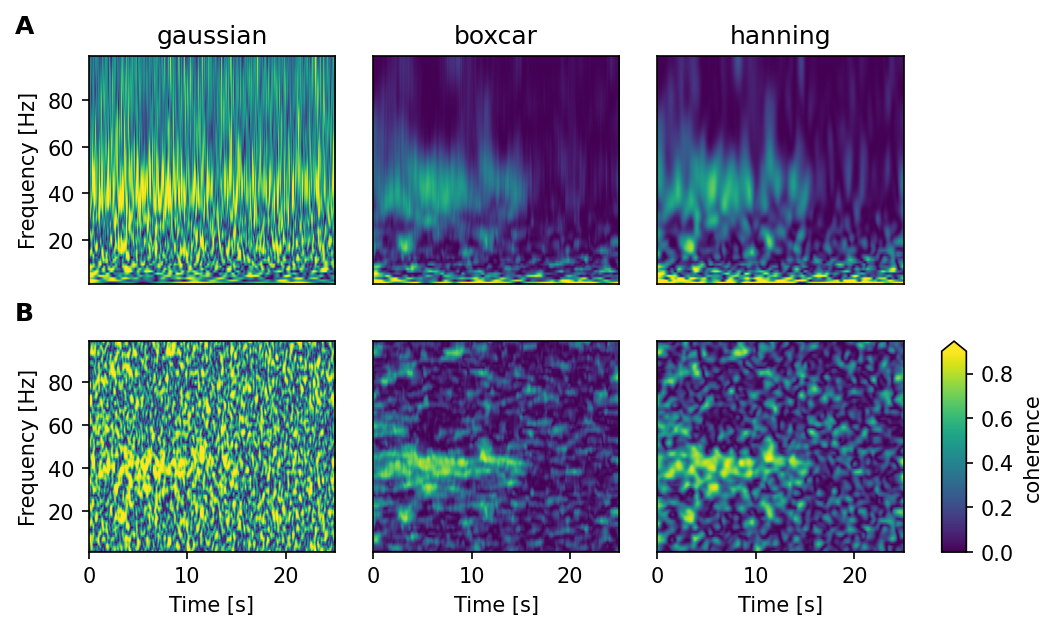

In [10]:
fig = plt.figure(figsize=(6.5, 3.8), dpi=150)

gs1 = fig.add_gridspec(
    nrows=1,
    ncols=4,
    width_ratios=(1, 1, 1, 0.1),
    wspace=0.2,
    left=0.05,
    right=0.95,
    bottom=0.55,
    top=0.95,
)
gs2 = fig.add_gridspec(
    nrows=1,
    ncols=4,
    width_ratios=(1, 1, 1, 0.1),
    wspace=0.2,
    left=0.05,
    right=0.95,
    bottom=0.08,
    top=0.45,
)

# Panel A
ax1 = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[1])
ax3 = plt.subplot(gs1[2])
# ax4 = plt.subplot(gs1[3])

extent = [0, N / Fs, freqs[0], freqs[-1]]


plt.sca(ax1)
plt.imshow(
    sC1, aspect="auto", cmap="viridis", origin="lower", extent=extent, vmin=0, vmax=0.9
)
plt.xticks([])
plt.ylabel("Frequency [Hz]")
plt.title("gaussian")
plt.sca(ax2)
plt.imshow(
    c_square1,
    aspect="auto",
    cmap="viridis",
    origin="lower",
    extent=extent,
    vmin=0,
    vmax=0.9,
)
plt.xticks([])
plt.yticks([])
plt.title("boxcar")
plt.sca(ax3)
plt.imshow(
    c_hanning1,
    aspect="auto",
    cmap="viridis",
    origin="lower",
    extent=extent,
    vmin=0,
    vmax=0.9,
)
plt.xticks([])
plt.yticks([])
plt.title("hanning")

# Panel B
ax5 = plt.subplot(gs2[0])
ax6 = plt.subplot(gs2[1])
ax7 = plt.subplot(gs2[2])
ax8 = plt.subplot(gs2[3])

plt.sca(ax5)
plt.imshow(
    sC2, aspect="auto", cmap="viridis", origin="lower", extent=extent, vmin=0, vmax=0.9
)
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.sca(ax6)
plt.imshow(
    c_square2,
    aspect="auto",
    cmap="viridis",
    origin="lower",
    extent=extent,
    vmin=0,
    vmax=0.9,
)
plt.yticks([])
plt.xlabel("Time [s]")
plt.sca(ax7)
plt.imshow(
    c_hanning2,
    aspect="auto",
    cmap="viridis",
    origin="lower",
    extent=extent,
    vmin=0,
    vmax=0.9,
)
plt.yticks([])
plt.xlabel("Time [s]")

norm = matplotlib.colors.Normalize(vmin=0, vmax=0.9)
cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=matplotlib.cm.viridis, norm=norm),
    cax=ax8,
    extend="max",
    shrink=0.1,
)
cbar.ax.set_ylabel("coherence", rotation="vertical")

plot.add_panel_letters(
    fig, axes=[ax1, ax5], fontsize=12, xpos=[-0.3, -0.3], ypos=[1.1, 1.1]
)

plt.savefig("img/n3.0.6/effect_sm_kernel.pdf", bbox_inches="tight")